In [3]:
import pandas as pd
import numpy as np
from time import time
from scipy import sparse
import matplotlib.pylab as plt

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import cross_val_score,  train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import adjusted_mutual_info_score, calinski_harabaz_score, silhouette_score

In [4]:
%matplotlib inline

In [5]:
def prepare_data(features_selection ='all'):
    train = (pd.read_csv('../data/train.csv', na_values=-1)
           .fillna(value=999))
            
    test  = (pd.read_csv('../data/test.csv', na_values=-1)
               .fillna(value=999)) 
    test_id = test.id
    y = train.target.values
    train = train.drop(['id','target'], axis=1)

    features = train.columns
    
    features_bin = [i for i in features if set(i)&set('bin')==set('bin')]
    features_cat = [i for i in features if set(i)&set('cat')==set('cat')]
    features_con = list(set(features) - (set(features_bin)|set(features_cat)))

    if features_selection == 'all':
        feature_category = features
    elif features_selection == 'ind':
        feature_category = [i for i in features if set(i)&set('ind')==set('ind')]
    elif features_selection == 'reg':
        feature_category = [i for i in features if set(i)&set('reg')==set('reg')]
    elif features_selection == 'car':
        feature_category = [i for i in features if set(i)&set('car')==set('car')]
    elif features_selection == 'calc':
        feature_category = [i for i in features if set(i)&set('calc')==set('calc')]    
    
    cat_features = list(set(feature_category)&set(features_cat))
    train_cat, test_cat =[], []
    if len(cat_features)>0:
        train_cat = np.array(train[cat_features])
        train_cat[:,:] = np.add(train_cat[:,:],np.ones((train_cat.shape[0],train_cat.shape[1])))
        test_cat  = np.array(test[cat_features])
        test_cat[:,:] =  np.add(test_cat[:,:],np.ones((test_cat.shape[0],train_cat.shape[1])))

        OH = OneHotEncoder()
        OH.fit(np.array(list(train_cat) + list(test_cat)))
        train_cat = OH.transform(train_cat).toarray()
        test_cat = OH.transform(test_cat).toarray()
    
    con_features = list(set(feature_category)&set(features_con))
    train_con, test_con = [], []
    if len(con_features)>0:
        train_con = np.array(train[con_features])
        test_con  = np.array(test[con_features])
        RS = StandardScaler()
        RS.fit(list(train_con) + list(test_con))
        train_con = RS.transform(train_con)
        train_con = RS.transform(train_con)
    
    bin_features = list(set(feature_category)&set(features_bin))

    train_bin = np.array(train[bin_features])
    test_bin = np.array(test[bin_features])

    if len(cat_features)==0:
        X = np.hstack((train_con,train_bin))
        X_test = np.hstack((test_con,test_bin))
    else:
        X = np.hstack((train_cat,train_con,train_bin))
        X_test = np.hstack((test_cat,test_con,test_bin))

    
    
    return X, y, X_test, test_id

In [6]:
def add_kmeans_features():
    #calc
    X, y, X_test, _ = prepare_data('ind')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_ind = mbk.predict(X)
    label_test_ind = mbk.predict(X_test)
    
    #car
    X, y, X_test, _ = prepare_data('car')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=5, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_car = mbk.predict(X)
    label_test_car = mbk.predict(X_test)
    
    #reg
    X, y, X_test, _ = prepare_data('reg')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=5, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_reg = mbk.predict(X)
    label_test_reg = mbk.predict(X_test)
    
    #car
    X, y, X_test, _ = prepare_data('calc')
    X_all = np.vstack((X, X_test))
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X_all)
    label_train_calc = mbk.predict(X)
    label_test_calc = mbk.predict(X_test)
    
    X, y, X_test, test_id = prepare_data('all')
    
    X = np.hstack((X, label_train_calc[:, np.newaxis],label_train_car[:, np.newaxis], label_train_reg[:, np.newaxis], label_train_calc[:, np.newaxis]))
    X_test = np.hstack((X_test, label_test_calc[:, np.newaxis], label_test_car[:, np.newaxis], label_test_reg[:, np.newaxis], label_test_calc[:, np.newaxis]))
    
    return X, y, X_test, test_id

In [121]:
X, y, X_test, _ = prepare_data('all')

In [140]:
X, y, X_test, test_id = add_kmeans_features()

135113124 595212 595212 595212 595212


In [103]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=512, stratify=y, shuffle=True)

In [15]:
X, y, X_test, _ = prepare_data('reg')
X = np.vstack((X, X_test))

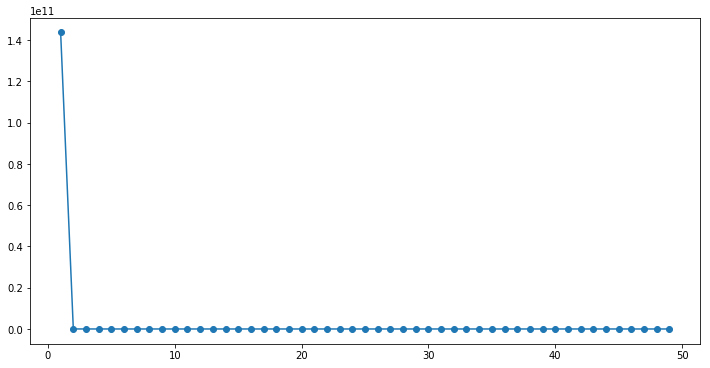

In [16]:
scores = []
nclusters =[]
for clusters in range(1,50):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=clusters, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)
    mbk.fit(X)
    scores.append(mbk.inertia_)
    nclusters.append(clusters)
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(clusters, mbk.inertia_))
clusters_df = pd.DataFrame( { "num_clusters":nclusters, "cluster_errors": scores } )
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.show()

In [86]:
mbk = MiniBatchKMeans(init='k-means++', n_clusters=8, batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0, compute_labels=True)

In [87]:
mbk.fit(X_all)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=10, random_state=0, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [88]:
label_train = mbk.predict(X)

In [89]:
label_test = mbk.predict(X_test)

In [93]:
label_test.shape

(892816,)